# Training models for Factorizable Library generation

This notebook serves as a demo for training models for use in generating Stochastically Annealed Product Space (SAPS) libraries as presented by _Dai & Saksena et. al. 2022_. Here, an example of training a reverse kernel model using ranibizumab affinity selection data is presented. 

## Brief background on Google Colab

Google Colab is a free cloud-based service that combines the interactive execution environment of Jupyter Notebooks with cloud compute. A good introduction to Google Colab can be found [here](https://colab.research.google.com/notebooks/welcome.ipynb).

Google Colab notebooks can be used with GPU acceleration. If you haven't already, make a copy of the notebook to your Drive by going to File->Save A Copy In Drive so that you can edit the notebook. To enable GPU acceleration, go to Runtime->Change runtime type and select GPU under Hardware accelerator. In the top right corner, there should also be a green tick indicating you are connected to a hosted runtime. If not, click to reconnect. More information is available [here](https://colab.research.google.com/notebooks/gpu.ipynb)

Then, if correctly set up, `nvidia-smi` should return information about the available GPU. 

In [1]:
!nvidia-smi

Thu Dec  1 07:14:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Clone into FactorizableLibrary github repo
This will automatically load in example datasets for running SAPS. Here, we will train dot product models

In [2]:
!git clone https://github.com/gifford-lab/FactorizableLibrary.git
%cd FactorizableLibrary/model_training/

Cloning into 'FactorizableLibrary'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 412 (delta 25), reused 87 (delta 25), pack-reused 324
Receiving objects: 100% (412/412), 292.15 MiB | 16.51 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Checking out files: 100% (317/317), done.
/content/FactorizableLibrary/model_training


In [3]:
import os

import numpy as np
from scipy import stats
from scipy.special import softmax
import math
import random
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data
from torch.nn.parameter import Parameter
from torch.nn import init

from tqdm import tqdm

In [4]:
torch.cuda.set_device(0)

## Load in data helper functions

- process() prepares csv data for training by padding and one-hot encoding sequences. 
- toTensorDataset() prepares torch TensorDatasets for easy loading into PyTorch models.
- getData() is a wrapper for both functions to get train and test sets.

In [5]:
def process(data):
    with open("./encoding.pkl", 'rb') as fin:
        onehot = pickle.load(fin)
        
    inputs = []
    labels = []
    ranges = []
    for aa, v in data:
        extra = 40-len(aa)
        r = math.floor(extra/2)
        l = math.ceil(extra/2)
        aa = np.array([onehot[c] for c in ('J'*r) + aa + ('J'*l)]).T
        rng = (40-l-20, r)
        
        inputs.append(aa)
        labels.append(float(v))
        ranges.append(rng)
    return inputs, labels, ranges
    
def toTensorDataset(datalist):
    torchds = torch.utils.data.TensorDataset(torch.tensor(np.concatenate([data[0] for data in datalist]), dtype = torch.float32),
                                             torch.tensor(np.concatenate([data[1] for data in datalist]), dtype = torch.float32),
                                             torch.tensor(np.concatenate([data[2] for data in datalist]), dtype = torch.int64))
    return torchds

def getData(fname):
    with open(fname, 'rb') as fin:
        train, test = pickle.load(fin)
        
    train = [process(z) for z in train]
    test = process(test)
    test = torch.utils.data.DataLoader(toTensorDataset([test]), batch_size=1000, shuffle=False, num_workers=2, drop_last=False)
    return train, test

## Define model classes 
- ResBlock() class is a general residual layer. 
- EmbedderNet() generates sequence embeddings. 

### Different model types
- Predictor_Dot() is referred to in the manuscript as "reverse kernel model" and uses the dot product of two segment embeddings to learn a score. 
- Predictor_Plus() is referred to in the manuscript as "independent model" and learns a score using each segment embedding independently and sums. 
-Predictor_Joint() is referred to in the manuscript as the "unrestricted model" and learns a score using the full length sequence, thereby leveraging all available information. 

In [11]:
class ResBlock(nn.Module):
    def __init__(self, channels, dilation):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation)
        self.conv1_bn = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation)
        self.conv2_bn = nn.BatchNorm1d(channels)
        
    def forward(self, x):
        x1 = F.relu( self.conv1_bn( self.conv1(x) ) )
        return self.conv2_bn( self.conv2(x1) ) + x

class EmbedderNet(nn.Module):
    def __init__(self, length, channels, outchannels):
        super(EmbedderNet, self).__init__()
        self.length = length
        
        self.pool = nn.MaxPool1d(2, 2, ceil_mode = True)
        self.conv = nn.Conv1d(40, channels, 1, 1, 0)
        self.conv_bn = nn.BatchNorm1d(channels)
        
        self.block1 = ResBlock(channels, 1)
        self.block2 = ResBlock(channels, 1)
        self.block3 = ResBlock(channels, 1)
        self.block4 = ResBlock(channels, 1)
        self.block5 = ResBlock(channels, 1)
        
        self.embed_1 = nn.Linear( int( channels*math.ceil(math.ceil(self.length/2)/2) ) , 128)
        self.embed_2 = nn.Linear(128, outchannels)

        # deprecated positional encoding
        position = ( (torch.tensor([i for i in range(self.length)]).view(-1,1)
                      - torch.tensor([i for i in range(self.length)]).view(1,-1)) )
        stack = []
        for i in range(-self.length+1, self.length):
            stack.append((position == i).float())
        positioncode = torch.stack(stack).view(1,(2*self.length-1),self.length,self.length)
        
        self.register_buffer("position", positioncode)
        
    def forward(self, x):
        batchsize = x.shape[0]
        x = F.relu( self.conv_bn( self.conv(x) ) )
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool( self.block4(x) )
        x = self.pool( self.block5(x) ).view(batchsize,-1)
        return self.embed_2( F.relu( self.embed_1(x) ) )

class Predictor_Dot(nn.Module):
    def __init__(self):
        super(Predictor_Dot, self).__init__()
        self.embedSeed = EmbedderNet(10, 64, 16)
        
        
    def forward(self, x):
        seed = x
        
        return torch.sum(self.embedSeed(seed), dim = 1)
    
class Predictor_Plus(nn.Module):
    def __init__(self):
        super(Predictor_Plus, self).__init__()
        self.embedSeed = EmbedderNet(10, 64, 1)
        
        
    def forward(self, x):
        seed = x

        return self.embedSeed(seed) 
    
class Predictor_Joint(nn.Module):
    def __init__(self):
        super(Predictor_Joint, self).__init__()
        self.predictor = EmbedderNet(20, 64, 1)
        
    def forward(self, x):
        return self.predictor(x)

## Define training functions
- RandomPadding() implements the random padding procedure described in the manuscript. 
- validate() applies a trained model to held-out test data to evaluate performance. 
- getTrainingValidationSplit() splits data into train and test sets and returns train/test Torch DataLoaders. 
- trainNet() trains specified model. 

In [7]:
def RandomPadding(inputs, bounds):
    bounds = bounds.permute((1,0))
    indexes = np.random.randint(bounds[0], bounds[1]+1).reshape(-1,1)
    gatherindex = torch.tensor(
        np.array([i for i in range(20)]).reshape(1,-1) + indexes,
        dtype = torch.int64 )
    gatherindex = gatherindex.view(-1,1,20).repeat(1,40,1)
    
    result = torch.gather(inputs, 2, gatherindex)
    return result

def FixedPadding(inputs, bounds):
    bounds = bounds.permute((1,0))
    indexes = np.ones(bounds[0].shape[0]).reshape(-1,1)*10
    gatherindex = torch.tensor(
        np.array([i for i in range(20)]).reshape(1,-1) + indexes,
        dtype = torch.int64 )
    gatherindex = gatherindex.view(-1,1,20).repeat(1,40,1)
    
    result = torch.gather(inputs, 2, gatherindex)
    return result

def validate(net, loader, paddingFunction):
    predictions = []
    targets = []
    if len(loader) == 0:
        return np.array([]), np.array([])
    with torch.no_grad():
        pbar = tqdm(loader, position=0, leave=True)
        for (data, target, bounds) in pbar:
            data = paddingFunction(data, bounds).cuda()
            predictions.append( net(data).cpu().numpy().reshape(-1) )
            targets.append( target.numpy().reshape(-1) )
        predictions = np.concatenate(predictions)
        targets = np.concatenate(targets)
        return predictions, targets

def getTrainingValidationSplit(data, i):
    t = toTensorDataset( data[:i] + data[i+1:] )
    v = toTensorDataset([data[i]])
    trainloader = torch.utils.data.DataLoader(t, batch_size=100, shuffle=True, num_workers=2, drop_last=True)
    valloader = torch.utils.data.DataLoader(v, batch_size=1000, shuffle=False, num_workers=2, drop_last=False)
    return trainloader, valloader

# epochs: Number of training epochs
# train_loader: Dataloader for training data
# validation_loader: Dataloader for validation data
# modelname: Descriptive name for model. Can be anything
# architecture: Predictor_Dot, Predictor_Joint, or Predictor_Plus
# paddingFunction: RandomPadding or FixedPadding
def trainNet(epochs, train_loader, validation_loader, modelname, architecture, paddingFunction):
    """
    Inputs:
    --------
    epochs: Number of training epochs (type: int)
    train_loader: Dataloader for training data (type: torch.utils.DataLoader)
    validation_loader: Dataloader for validation data (type: torch.utils.DataLoader)
    modelname: Descriptive name for model. Can be anything (type: str)
    architecture: Predictor_Dot, Predictor_Joint, or Predictor_Plus (type: torch.nn.Module)
    paddingFunction: RandomPadding or FixedPadding (type: func)

    Outputs:
    ---------
    net: Trained model (torch.nn.Module)
    """
    net = architecture().cuda()
    optimizer = torch.optim.Adam(net.parameters())
    lossfunc = nn.MSELoss()
    
    losses = []
    loss_trace = []
    validation_trace = []
    bestr = float('-inf')
    for i in range(epochs):
        losses = []
        net = net.train()
        pbar = tqdm(train_loader, position=0, leave=True)
        for (data, target, bounds) in pbar:
            optimizer.zero_grad()
            data = paddingFunction(data, bounds).cuda()
            output = net(data)
            
            loss = lossfunc(output.reshape(-1), target.cuda() )
            
            loss.backward()
            optimizer.step()
            
            current_loss = loss.item()
            losses.append(current_loss)
            
            pbar.set_description("Batch {}: loss_avg = {:.5f}, loss_now = {:.5f}".format(i, np.mean(losses), current_loss ))
        net = net.eval()
        valx, valy = validate(net, validation_loader, paddingFunction)
        r = stats.pearsonr(valx, valy)[0]
        validation_trace.append(r)
        print ("Epoch {}: r={}".format(i,r))
        
        if r > bestr:
            torch.save(net.state_dict(), "./weights/{}_best.pt".format(modelname))
            bestr = r
        loss_trace.append(losses)

    net = architecture()
    net.load_state_dict(torch.load( "./weights/{}_best.pt".format(modelname), map_location='cpu' ))
    net.eval()
    return net, loss_trace, validation_trace

## Train models 
- Below are the steps for training the model using above defined functions and classes. 
- Note, as we are computing on public GPUs available by Google CoLab, this demo only reflects results for training for 2 epochs. 

In [8]:
# Load in data
training_splits, test_loader = getData("./data/baculovirus_extract_log_enrichment.pkl")

In [13]:
# Train the model
model, losses, performance_trace = trainNet(
    2, *getTrainingValidationSplit(training_splits, 0), "testrun", Predictor_Joint, RandomPadding)

100%|██████████| 3/3 [00:00<00:00, 14.42it/s]


Epoch 0: r=0.8215307680941909


100%|██████████| 3/3 [00:00<00:00, 14.74it/s]

Epoch 1: r=0.8462645221032449


In [14]:
# Validate the model
predictions, values = validate(model.cuda(), test_loader, FixedPadding)
stats.pearsonr(predictions, values)

100%|██████████| 7/7 [00:00<00:00, 26.54it/s]


(0.8622880063525042, 0.0)

Text(0, 0.5, 'Predicted affinity')

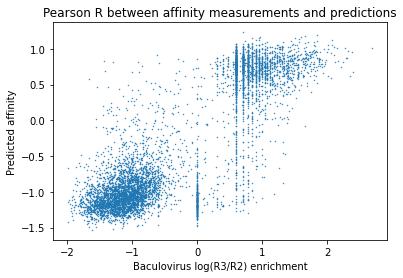

In [15]:
import matplotlib.pyplot as plt
plt.scatter(values, predictions, s=0.2)
plt.title("Pearson R between affinity measurements and predictions")
plt.xlabel("Baculovirus log(R3/R2) enrichment")
plt.ylabel("Predicted affinity")